In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt
%matplotlib inline

# Algoritmo Genético (simples) para Solução do Problema da Mochila

O algoritmo genético a seguir implementa uma solução simples para o problema da mochila tradicional. O problema da mochila (*Knapsack problem*) é um problema de otimização definido como segue: 

$$
\max{\sum_{i=1}^{n} v_i x_i }
$$

sujeito a

$$
\sum_{i=i}^{n} p_i x_i \leq L
$$

tal que 

\begin{gather*}
x_i \in \{0,1\}\\
v_i \in \mathbb{Z}^+\\
p_i \in \mathbb{Z}^+\\
L \in \mathbb{Z}^+
\end{gather*}

Uma abstração comum para o problema da mochila consiste em: dado um conjunto *n* itens, cada um com peso $p_i$ e um valor associado $v_i$. Deve-se selecionar itens tal que a soma total dos valores seja a máxima possível, respeitando o limite de peso total $L$. Cada índice $x_i$ do vetor de itens selecionados $\mathbf{x} \in  \{0,1\}^n$ indica se o item $i$ foi selecionado ou não para compor a solução.

**A implementação abaixo está intencionalmente simples para ficar mais fácil compreender. Por exemplo, dá para otimizar bastante calculando todos os produtos escalares usando *numpy*.**

In [2]:
#Carregar instâncias no formato kplib (https://github.com/likr/kplib)
#retorna o número de itens, o limite de peso total, o vetor de valores e o vetor de pesos
def carregar_instancia(nome_arquivo):
    with open(nome_arquivo, 'r') as f:
        l = f.readlines()
        l = [i.strip() for i in l]
        n = int(l[1])
        limite = int(l[2])
        valores, pesos = zip(*[(int(dado.split(" ")[0]), int(dado.split(" ")[1])) for dado in l[4:]])
        return n, limite, valores, pesos

#Calcula a soma dos itens selecionados
def calcular_peso(solucao, pesos):
    peso = 0
    for idx, i in enumerate(solucao):
        if i == 1:
            peso += pesos[idx]
    return peso

In [3]:
#Retorna uma função fitness parametrizada com os valores, pesos e o limite de peso total
#Esta função fitness recebe uma solução e retorna o valor total da solução. Caso o peso 
#da solução exceda o limite, a função retorna fitness 0.
def get_fitness_fn(valores, pesos, limite):
    def fitness(solucao):
        valor = 0
        peso = 0
        for idx, i in enumerate(solucao):
            if i == 1:
                valor += valores[idx]
                peso  += pesos[idx]
        if peso > limite:
            valor = 0
        return valor
    return fitness

In [4]:
#Retorna uma população inicial contendo tam_pop vetores binários aleatórios com n_itens posições
def gen_pop(tam_pop, n_itens):
    return np.random.randint(0, 2, (tam_pop, n_itens))     

In [5]:
#Operador genético de reprodução
#Recebe duas soluções e as combina usando um único ponto de corte.
#Retorna apenas um indivíduo
def reproduzir(x, y):
    n_itens = len(x)
    corte = np.random.randint(0, n_itens)
    novo = np.zeros(n_itens).astype(int)
    novo[0:corte] = x[0:corte]
    novo[corte:n_itens] = y[corte:n_itens]
    return novo

In [6]:
#Função auxiliar para computar a soma de prefixo
def acumular(v):
    acum = 0
    r = []
    for i in v:
        r.append(i + acum)
        acum = r[-1]
    return r

In [7]:
#Função de seleção de indivíduo que escolhe com maior probabilidade 
#os indivíduos mais aptos.
#Recebe como entrada a população e a função de fitness, retorna um indivíduo
def selecionar_individuo(pop, f):
    #calcula fitness de cada indivíduo
    fits = list(map(f, pop)) 
    #calcula a soma das fitness
    soma = sum(fits)
    #normaliza as fitness de cada indivíduo
    norms = list(map(lambda x,y: x / y, fits, [soma] * len(pop)))
    #calcula a soma de prefixo
    acum = list(acumular(norms))
    #"roda" a roleta
    r = np.random.random()
    for i in range(len(acum)):
        if r < acum[i]:
            break
    return pop[i]

In [8]:
#Retorna uma função que retorna True com probabilidade prob/100.
def mut_prob_constante(prob):
    def uniform():
        return True if np.random.randint(0,100) < prob else False
    return uniform

#Realiza uma mutação: inverte um bit aleatório da solução
def mutar(solucao):
    r = np.random.randint(0, len(solucao))
    solucao[r] = 1 - solucao[r]
    return solucao

In [9]:
def argmax(v):
    m = 0
    for i in range(len(v)):
        if v[i] > v[m]:
            m = i
    return m
    
#Algoritmo genético clássico, como em Russell e Norvig(2010)
#Recebe a população inicial, função fitness, função retorna true com probabilidade conhecida
#número de iterações e uma flag indicando se deve mostrar um gráfico da convergência.
#Retorna a população final e o melhor indivíduo
def genetico(pop_inicial, f, mut_prob_f, iters=100, graph=True):
    pop = pop_inicial
    max_fits = []
    mean_fits = []
    best_solution = (pop[argmax(list(map(f,pop)))])
    
    for i in range(iters):
        nova_pop = []
        for p in range(len(pop)):
            x = selecionar_individuo(pop, f)
            y = selecionar_individuo(pop, f)
            filho = reproduzir(x,y)
            if mut_prob_f():
                filho = mutar(filho)
            nova_pop.append(filho)
        pop = nova_pop
        fits = list(map(f, pop))
        max_fits.append(max(fits))
        mean_fits.append(sum(fits) / len(fits))
        
        if max_fits[-1] > f(best_solution):
            best_solution = pop[argmax(fits)]
        
    if graph:
        #%matplotlib tk
        plt.figure()
        plt.plot(range(iters), mean_fits, label='Fitness médio')
        plt.plot(range(iters), max_fits, label='Fitness máximo')
        plt.legend()
        plt.ylabel('Fitness')
        plt.xlabel('Gerações')
        plt.show()   
        
    return pop, best_solution


Número de itens: 50, limite de peso: 14778


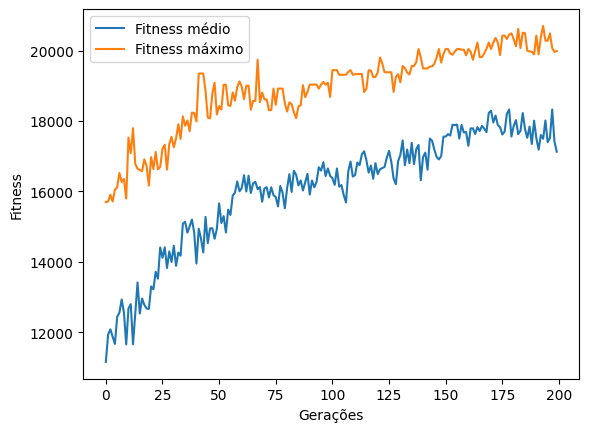

Melhor solução encontrada: [0 1 1 0 1 0 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 1 0 0 0
 0 1 0 0 1 1 0 0 1 0 1 0 1], valor = 20699, peso = 14713


In [10]:
#Número de iterações (gerações)
N_ITERACOES = 200
#Tamanho da população
TAM_POP = 100
#Probabilidade de um indivíduo sofrer mutação
PROB_MUT = 5
#Nome do arquivo que contém uma instância a ser resolvida
INSTANCIA = "s000.kp"

#Carregar a instância
n_itens, limite, valores, pesos = carregar_instancia(INSTANCIA)
print("Número de itens: %d, limite de peso: %d" % (n_itens, limite))
#Gerar a população inicial
pop_inicial = gen_pop(TAM_POP, n_itens)
#Gerar a função que retorna true com probabilidade PROB_MUT
mutacao_prob_f = mut_prob_constante(PROB_MUT)
#Instancia a função fitness com os dados da instância
fitness = get_fitness_fn(valores, pesos, limite)
#Executar o algoritmo genético
res, melhor = genetico(pop_inicial, fitness, mutacao_prob_f, iters=N_ITERACOES, graph=True)

print("Melhor solução encontrada: %s, valor = %d, peso = %d" % (str(melhor), fitness(melhor), calcular_peso(melhor, pesos)))

# Solução Gulosa

In [33]:
def gulosa(n_itens, limite, valores, pesos):
    solucao = np.zeros(n_itens).astype(int)
    peso = 0
    valor = 0
    sorted_idxs = list(reversed(np.argsort(valores)))
    for idx in sorted_idxs:
        if peso + pesos[idx] > limite:
            break
        solucao[idx] = 1
        peso += pesos[idx]
        valor += valores[idx]
    return solucao, peso, valor
        

In [34]:
INSTANCIA = "s000.kp"

n_itens, limite, valores, pesos = carregar_instancia(INSTANCIA)
solucao, peso, valor = gulosa(n_itens, limite, valores, pesos)
print("Solução da abordagem gulosa: %s, valor = %d, peso = %d\n" % (solucao, valor, peso))

Solução da abordagem gulosa: [1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1
 0 1 1 0 0 1 0 0 1 0 0 0 1], valor = 19065, peso = 13911

